In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, roc_curve, auc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets
import nibabel as nib
from torchvision.transforms import functional as F
from natsort import natsorted
from torchvision.models import swin_t, Swin_T_Weights
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
class SwinT(nn.Module):
    def __init__(self):
        super(SwinT, self).__init__()
        self.model1 = swin_t(weights = Swin_T_Weights.IMAGENET1K_V1)
        
        self.fc1 = nn.Linear(1000, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.model1(x)
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x

In [3]:
import os
os.environ['https_proxy'] = 'http://menloproxy.cumc.columbia.edu:8080'

os.environ['http_proxy'] = 'http://menloproxy.cumc.columbia.edu:8080'

In [4]:
model = SwinT()
model.model1.features[0][0] = nn.Conv2d(1, 96, kernel_size=(4, 4), stride=(4, 4))
model

SwinT(
  (model1): SwinTransformer(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): Permute()
        (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      )
      (1): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): ShiftedWindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (proj): Linear(in_features=96, out_features=96, bias=True)
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): MLP(
            (0): Linear(in_features=96, out_features=384, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=384, out_features=96, bias=True)
            (4): Dropout(p=0.0, inplace=Fals

In [5]:
def downsize_transform(data): 
    # Convert the NumPy array to a PyTorch tensor
    tensor_data = torch.from_numpy(data).unsqueeze(0)  # Add channel dimension

    # Define the resize and crop sizes
    resize = transforms.Resize(256)  # Resize so the smallest side is at least 224
    crop = transforms.CenterCrop(224)
    
    # Apply the transformations
    tensor_data = resize(tensor_data)
    tensor_data = crop(tensor_data)

    # Assuming normalization might be necessary based on your model's requirement
    # Normalize using a standard mean and std or as per your dataset's requirement
    # Example for a single-channel image, using arbitrary mean and std

    return tensor_data

In [5]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transforms = None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.cn_dir = os.path.join(self.root_dir, "MNI152_affine_WB_iso1mm/CN")
        self.scz_dir = os.path.join(self.root_dir, "MNI152_affine_WB_iso1mm/schiz")
        self.samples, self.labels = self._load_samples()

    def _load_samples(self):
        samples = []
        
        samples = [file for file in os.listdir(self.cn_dir) if file.endswith(".nii.gz")]
        labels = [0] * len(samples)
        samples += [file for file in os.listdir(self.scz_dir) if file.endswith(".nii.gz")]
        labels += [1] * (len(samples) - len(labels))

        return samples, labels

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        label = self.labels[idx]
        if label == 0:
            file_path = os.path.join(self.cn_dir, self.samples[idx])
        else:
            file_path = os.path.join(self.scz_dir, self.samples[idx])

        # Load the NIfTI image
        img = nib.load(file_path)

        # Get the image data array
        img_data = np.float32(img.get_fdata())[0:192, 114, 0:192]
        if self.transforms:
            img_tensor = self.transforms(img_data)
        else:
            img_tensor = torch.from_numpy(img_data).unsqueeze(0)
        return img_tensor, label

In [6]:
root_dir = "/home/ljd2160/research/youzhi/test/bme_project/data"
folds_dir = [dir for dir in os.listdir(root_dir) if dir.startswith("fold")]
folds_dir = [os.path.join(root_dir, dir) for dir in folds_dir]
folds_dir = natsorted(folds_dir)
folds_dir

['/home/ljd2160/research/youzhi/test/bme_project/data/fold1',
 '/home/ljd2160/research/youzhi/test/bme_project/data/fold2',
 '/home/ljd2160/research/youzhi/test/bme_project/data/fold10']

In [9]:
dataloaders = []
for i in range(len(folds_dir)):
    fold_dir = folds_dir[i]
    dataset = CustomDataset(fold_dir) #, downsize_transform)
    dataloader = DataLoader(dataset, batch_size=200, shuffle=True)
    dataloaders.append(dataloader)
    print("fold", i+1, ": ", len(dataset))

fold 1 :  196
fold 2 :  188
fold 3 :  187


torch.Size([196, 1, 192, 192])
<built-in method type of Tensor object at 0x7f1329f48a90>
tensor([1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
        1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
        1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
        1, 1, 0, 0])


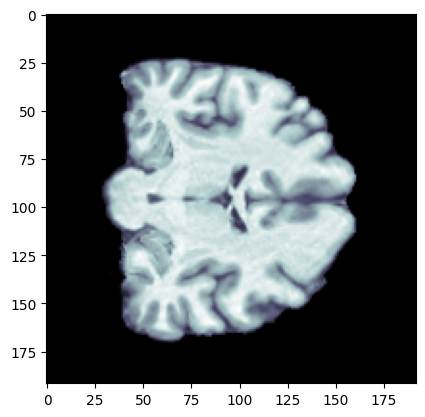

In [10]:
sample = next(iter(dataloaders[0]))
plt.imshow(sample[0][0][0], cmap = 'bone')
print(sample[0].shape)
print(sample[0].type)
print(sample[1])

torch.Size([192, 192])


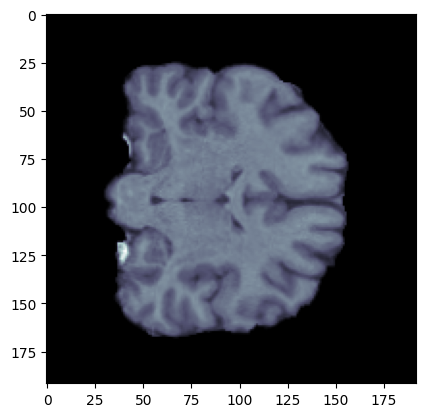

In [63]:
img = sample[0][0][0][0:192, 114, 0:192]
plt.imshow(sample[0][0][0][0:192, 114, 0:192], cmap='bone')
print(img.shape)

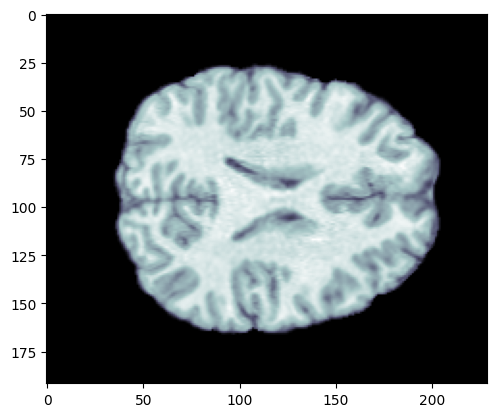

In [58]:
plt.imshow(sample[0][0][0][0:192, 0:229, 96], cmap='bone')

In [12]:
def train_net(net, epochs, train_dataloader, valid_loader, optimizer, loss_function):
    net.to(device)
    ret_train_loss = []
    ret_valid_loss = []

    for epoch in range(epochs):
        net.train()

        train_loss = []
        for i, (img, label) in enumerate(train_dataloader):
            img, label = img.to(device), label.float().unsqueeze(1).to(device)

            optimizer.zero_grad()
            y_pred = net(img)
            loss = loss_function(y_pred, label)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            print(f'{i + 1}/{len(train_dataloader)}| current training loss: {train_loss[-1]}', end='\r')

            # Deleting variables and emptying the cache might not always lead to significant memory savings
            # because PyTorch uses a caching memory allocator to improve performance. Consider using it
            # judiciously based on the actual memory footprint observed.
            del img, label, y_pred, loss
            torch.cuda.empty_cache()

        train_epoch_loss = np.mean(train_loss)
        ret_train_loss.append(train_epoch_loss)
        print(f'epoch {epoch}| training loss: {train_epoch_loss}', end='\r')

        # Validation phase
        net.eval()
        valid_loss = []
        with torch.no_grad():
            for i, (img, label) in enumerate(valid_loader):
                img, label = img.to(device), label.float().unsqueeze(1).to(device)
                y_pred = net(img)
                loss = loss_function(y_pred, label)
                valid_loss.append(loss.item())
                print(f'{i + 1}/{len(valid_loader)}| current validation loss: {valid_loss[-1]}', end='\r')

                del img, label, y_pred, loss
                torch.cuda.empty_cache()

        epoch_vloss = np.mean(valid_loss)
        print(f"epoch {epoch} | training loss: {train_epoch_loss:.4f} | validation loss: {epoch_vloss:.4f}")
        ret_valid_loss.append(epoch_vloss)

    return ret_train_loss, ret_valid_loss

In [15]:
def test_net(net, test_dataloader):
    net.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for i, (img, label) in enumerate(test_dataloader):
            img = img.to(device)
            y_pred = net(img)
            labels.append(label.numpy())
            predictions.append(y_pred.cpu().numpy())
    predictions = np.concatenate(predictions)
    labels = np.concatenate(labels)
    return predictions, labels


In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.BCELoss()
train_loss , valid_loss = train_net(model, 10, dataloaders[0], dataloaders[1], optimizer, loss_function)

epoch 0 | training loss: 0.6971 | validation loss: 1.9692
epoch 1 | training loss: 1.9967 | validation loss: 2.0831
epoch 2 | training loss: 2.0061 | validation loss: 0.6879
epoch 3 | training loss: 0.6996 | validation loss: 0.8149
epoch 4 | training loss: 0.7947 | validation loss: 0.6883
epoch 5 | training loss: 0.6899 | validation loss: 0.7260
epoch 6 | training loss: 0.7152 | validation loss: 0.6924
epoch 7 | training loss: 0.6944 | validation loss: 0.7077
epoch 8 | training loss: 0.7027 | validation loss: 0.7079
epoch 9 | training loss: 0.6907 | validation loss: 0.6877


In [16]:
pred, labels = test_net(model, dataloaders[0])

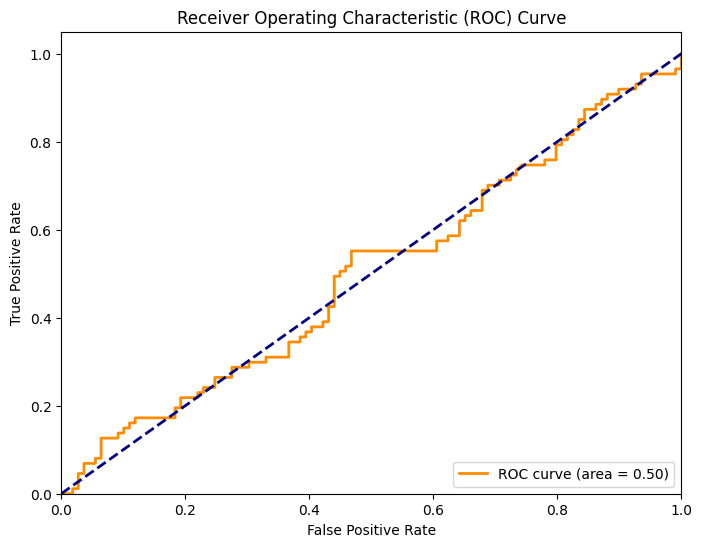

In [17]:
fpr, tpr, thres = roc_curve(labels, pred)
roc_auc = roc_auc_score(labels, pred)  # Calculate the ROC AUC score

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')  # Include the AUC score in the label
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [20]:
## check output:
sample = next(iter(dataloaders[0]))
img = sample[0].to(device)
label = sample[1].unsqueeze(1)
y_pred = model(img)
y_pred = y_pred.cpu().detach().numpy()
print(y_pred)
print(label.sum().item())

[[0.51591873]
 [0.5159178 ]
 [0.5159578 ]
 [0.51593465]
 [0.5159346 ]
 [0.515938  ]
 [0.5159508 ]
 [0.5159389 ]
 [0.51594675]
 [0.51596   ]
 [0.5159352 ]
 [0.5159264 ]
 [0.5159317 ]
 [0.51593024]
 [0.51594275]
 [0.51595706]
 [0.51594496]
 [0.51593655]
 [0.5159351 ]
 [0.5159392 ]]
5
